# Project - Fifth Requierement

### Import libraries and packages

In [84]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from copy import deepcopy
from tqdm import tqdm
from itertools import product
from collections import deque
from scipy.optimize import linprog

## Environment

In [85]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

In [86]:
class PricingEnvironmentMultiProductPiecewiseMean:
    def __init__(self, cost_vector, mean_valuation_schedule, std_valuations, buyers_per_round, total_rounds):
        """
        mean_valuations_list: list of 3 arrays, one for each interval (e.g. [mean_1, mean_2, mean_3])
        """
        self.cost_vector = np.array(cost_vector)
        self.mean_valuations_list = [np.array(m) for m in mean_valuation_schedule]
        self.std_valuations = np.array(std_valuations)
        self.buyers_per_round = buyers_per_round
        self.total_rounds = total_rounds
        self.current_round = 0

        # Compute the round thresholds
        self.interval_size = total_rounds // 3

    def round(self, p_t_vector):
        # Determine the current interval
        if self.current_round < self.interval_size:
            mean_valuations = self.mean_valuations_list[0]

        elif self.current_round < 2 * self.interval_size:
            mean_valuations = self.mean_valuations_list[1]

        else:
            mean_valuations = self.mean_valuations_list[2]


        # Compute the probability of buying and sample sales
        prob_buy = 1 - norm.cdf(np.array(p_t_vector), loc=mean_valuations, scale=self.std_valuations)
        num_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)

        # Compute reward
        reward = (np.array(p_t_vector) - self.cost_vector) * num_sales
        self.current_round += 1
        return num_sales, reward


### Global settings

In [87]:
# --- Global Settings ---

N = 3                       # Number of products
T = 20000                   # Time horizon
n_trials = 1               # Independent trials

# --- Pricing Grid and Product Info ---

cost_vector = np.array([2.0, 2.5, 3.0])             # Costs per product
initial_values = np.array([5.0, 6.0, 5.5])          # Initial mean valuations
std_valuations = np.array([1.0, 1.2, 0.8])          # Std for each product

min_p = 0.0
max_p = int(np.max(initial_values) * 2)

K = 10
P = np.linspace(min_p, max_p, K)                    # Shared price grid for all products

assert np.all(cost_vector < initial_values), "Each cost must be less than its initial valuation"

# --- Market and Inventory Parameters ---

B = 120000 * N                                      # Total shared inventory

amplitudes = np.array([2.0, 1.5, 1.0])
periods = np.array([1000, 1500, 800])

buyers_per_round = 50                               # Number of buyers per round

# --- Other Parameters ---

zoom_end = 2 * max(periods)     # Show only up to 2x the max period in main plots
zoom_end_mini = 200             # Show only up to 200 rounds in mini plots
zoom_end_5 = 5000               # Start zooming 5k rounds
s = 30                          # random seed

# --- Formatter for Millions in the plots---
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'


mean_valuation_schedule = [
    [5.0, 8.0, 2.0],  # T1
    [9.0, 5.0, 1.5],  # T2
    [1.5, 6.5, 12.0],  # T3
]

env = PricingEnvironmentMultiProductPiecewiseMean(
    cost_vector=cost_vector,
    mean_valuation_schedule=mean_valuation_schedule,
    std_valuations=std_valuations,
    buyers_per_round=buyers_per_round,
    total_rounds=T
)


### Agent definition

In [ ]:
class GlobalLinearProgramUCB_SW:
    def __init__(self, N, K, B, T, price_grids, scale=1.0):
        self.N = N
        self.K = K
        self.B = B
        self.T = T
        self.scale = scale
        self.price_grids = price_grids
        self.rho = B / T
        print(f"Using static rho = {self.rho}")
        self.t = 0
        self.inventory = B

        # All possible actions = super-arms
        self.actions = list(product(range(K), repeat=N))
        self.A = len(self.actions)

        # Sliding window size
        self.window_size = int(np.round(np.sqrt(T)))

        # Sliding-window buffers
        self.reward_window = [deque(maxlen=self.window_size) for _ in range(self.A)]
        self.sales_window = [deque(maxlen=self.window_size) for _ in range(self.A)]

        self.last_action_idx = None

    def pull_arm(self):
        if self.inventory < 1:
            self.last_action_idx = None
            return None

        if self.t < self.A:
            action_idx = self.t
        else:
            # Use windowed counts and means
            n_pulls = np.array([len(w) for w in self.reward_window])
            avg_rewards = np.array([np.mean(w) if len(w)>0 else 0 for w in self.reward_window])
            avg_sales   = np.array([np.mean(w) if len(w)>0 else 0 for w in self.sales_window])

            ucb = avg_rewards + self.scale * np.sqrt(2 * np.log(self.T) / np.maximum(1, n_pulls))
            lcb = avg_sales   - self.scale * np.sqrt(2 * np.log(self.T) / np.maximum(1, n_pulls))

            action_idx = self.solve_lp(ucb, lcb)

        self.last_action_idx = action_idx
        return self.actions[action_idx]

    def solve_lp(self, ucb_rewards, lcb_sales):
        c = -ucb_rewards
        A_ub = [lcb_sales]
        b_ub = [self.rho]
        A_eq = [np.ones(self.A)]
        b_eq = [1]
        bounds = [(0, 1)] * self.A

        res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
        if res.success:
            return np.random.choice(self.A, p=res.x)
        else:
            return np.argmax(ucb_rewards)

    def update(self, sales, total_reward):
        if self.last_action_idx is None:
            return

        idx = self.last_action_idx
       
        self.reward_window[idx].append(total_reward)
        self.sales_window[idx].append(np.sum(sales))

        
        self.inventory -= np.sum(sales)
        self.t += 1


In [ ]:
np.random.seed(s)

rewards_trials = []

for trial in range(n_trials):
    
    env = PricingEnvironmentMultiProductPiecewiseMean(
        cost_vector=cost_vector,
        mean_valuation_schedule=mean_valuation_schedule,
        std_valuations=std_valuations,
        buyers_per_round=buyers_per_round,
        total_rounds=T
    )

    
    learner = GlobalLinearProgramUCB_SW(
        N=N,
        K=K,
        B=B,
        T=T,
        price_grids=P,
        scale=1.0  
    )

    total_reward = np.zeros(T)

    for t in tqdm(range(T)):
        action = learner.pull_arm()
        if action is None:
            break  

        
        prices = [P[i] for i in action]

        sales, reward = env.round(prices)
        learner.update(sales, reward)

        total_reward[t] = np.sum(reward)

    rewards_trials.append(total_reward)


avg_reward = np.mean(rewards_trials, axis=0)


Using static rho = 18.0


 78%|███████▊  | 15612/20000 [06:09<01:43, 42.30it/s] 


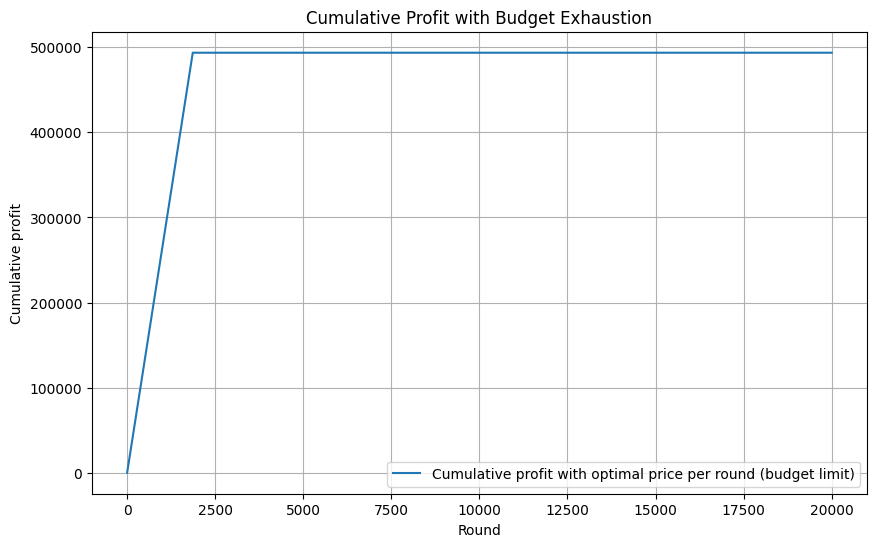

In [101]:
num_turns = len(mean_valuation_schedule)
rounds_per_turn = T // num_turns

profit_per_round = np.zeros(T)
cumulative_cost = 0

for turn_idx, mean_vals in enumerate(mean_valuation_schedule):
    start_round = turn_idx * rounds_per_turn
    end_round = (turn_idx + 1) * rounds_per_turn if turn_idx < num_turns - 1 else T

    for t in range(start_round, end_round):
        if cumulative_cost >= B:
           
            profit_per_round[t] = 0
            continue

        total_profit = 0
        total_cost = 0

        for i in range(N):
            mean_val = mean_vals[i]
            cost = cost_vector[i]
            std_val = std_valuations[i]

            
            expected_profits = []
            expected_demands = []
            for p in P:
                demand = buyers_per_round * (1 - norm.cdf(p, loc=mean_val, scale=std_val))
                profit = (p - cost) * demand
                expected_profits.append(profit)
                expected_demands.append(demand)
            expected_profits = np.array(expected_profits)
            expected_demands = np.array(expected_demands)

            idx_best = np.argmax(expected_profits)
            best_p = P[idx_best]
            best_demand = expected_demands[idx_best]
            best_profit = expected_profits[idx_best]

            cost_this_product = best_demand * cost

            
            budget_left = B - cumulative_cost
            if cost_this_product > budget_left:
                fraction = budget_left / cost_this_product
                best_demand *= fraction
                cost_this_product = budget_left
                best_profit = (best_p - cost) * best_demand

            total_profit += best_profit
            total_cost += cost_this_product

        profit_per_round[t] = total_profit
        cumulative_cost += total_cost

cum_profit = np.cumsum(profit_per_round)

plt.figure(figsize=(10, 6))
plt.plot(cum_profit, label='Cumulative profit with optimal price per round (budget limit)')
plt.xlabel("Round")
plt.ylabel("Cumulative profit")
plt.title("Cumulative Profit with Budget Exhaustion")
plt.legend()
plt.grid(True)
plt.show()



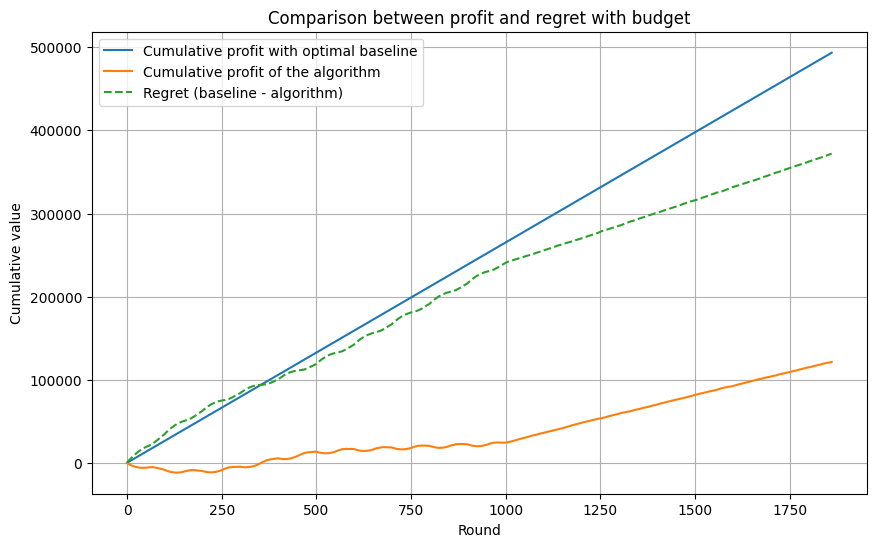

In [102]:
rewards_trials = np.array(rewards_trials)  

mean_rewards = np.mean(rewards_trials, axis=0) if rewards_trials.ndim == 2 else rewards_trials
cum_rewards = np.cumsum(mean_rewards)

budget_exhausted_round = np.argmax(profit_per_round == 0)  
if budget_exhausted_round == 0 and profit_per_round[0] != 0:
    
    budget_exhausted_round = T

cum_profit_trim = cum_profit[:budget_exhausted_round]
cum_rewards_trim = cum_rewards[:budget_exhausted_round]

regret = cum_profit_trim - cum_rewards_trim

plt.figure(figsize=(10, 6))
plt.plot(cum_profit_trim, label='Cumulative profit with optimal baseline')
plt.plot(cum_rewards_trim, label='Cumulative profit of the algorithm')
plt.plot(regret, label='Regret (baseline - algorithm)', linestyle='--')
plt.xlabel("Round")
plt.ylabel("Cumulative value")
plt.title("Comparison between profit and regret with budget")
plt.legend()
plt.grid(True)
plt.show()


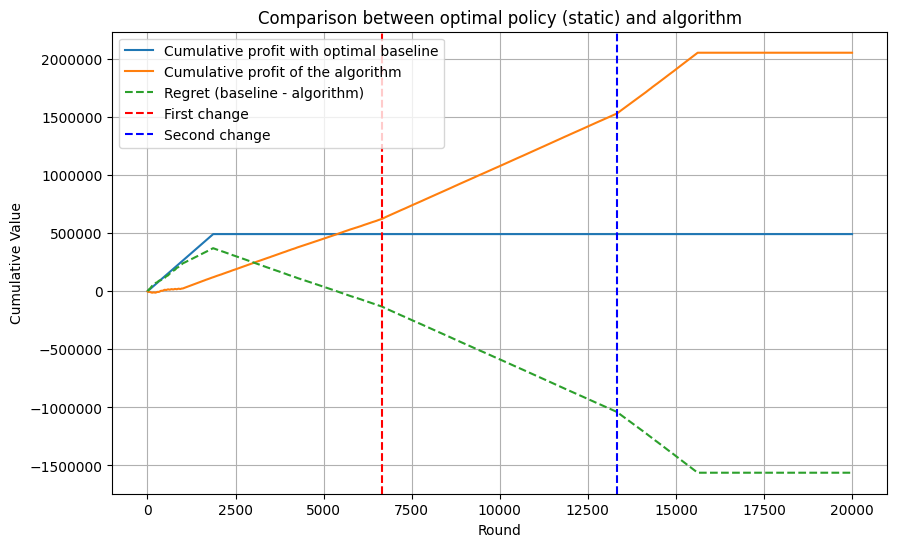

In [103]:
mean_rewards = np.mean(rewards_trials, axis=0) if rewards_trials.ndim == 2 else rewards_trials
cum_rewards = np.cumsum(mean_rewards)

budget_exhausted_round = np.argmax(profit_per_round == 0)  
if budget_exhausted_round == 0 and profit_per_round[0] != 0:
    budget_exhausted_round = T


cum_profit_trim = cum_profit[:budget_exhausted_round]

if budget_exhausted_round < T:
    plateau_value = cum_profit_trim[-1]
    cum_profit_trim = np.concatenate([cum_profit_trim, np.full(T - budget_exhausted_round, plateau_value)])


cum_rewards_trim = cum_rewards
if len(cum_rewards) < T:
    last_val = cum_rewards[-1]
    cum_rewards_trim = np.concatenate([cum_rewards, np.full(T - len(cum_rewards), last_val)])


regret = cum_profit_trim - cum_rewards_trim

x_axis = np.arange(1, T + 1)  

plt.figure(figsize=(10, 6))
plt.plot(x_axis, cum_profit_trim, label='Cumulative profit with optimal baseline')
plt.plot(x_axis, cum_rewards_trim, label='Cumulative profit of the algorithm')
plt.plot(x_axis, regret, label='Regret (baseline - algorithm)', linestyle='--')

plt.axvline(x=20000/3, color='red', linestyle='--', label='First change')
plt.axvline(x=20000/3*2, color='blue', linestyle='--', label='Second change')
plt.xlabel("Round")
plt.ylabel("Cumulative Value")
plt.title("Comparison between optimal policy (static) and algorithm")
plt.legend()
plt.grid(True)

plt.ticklabel_format(style='plain', axis='y')  

plt.show()